In [1]:
!pip install -q scikit-learn pandas matplotlib seaborn joblib torch re string collections

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


Using: cuda
Loading data...
Variants: (3321, 4)
Final: (3321, 5)
Training on GPU...
Epoch 1 | F1: 0.033 | AUC: 0.497
  → Saved best model
Epoch 2 | F1: 0.033 | AUC: 0.497
  → Saved best model
Epoch 3 | F1: 0.047 | AUC: 0.525
  → Saved best model
Epoch 4 | F1: 0.050 | AUC: 0.546
  → Saved best model
Epoch 5 | F1: 0.066 | AUC: 0.538
Epoch 6 | F1: 0.050 | AUC: 0.552
  → Saved best model
Epoch 7 | F1: 0.050 | AUC: 0.571
  → Saved best model
Epoch 8 | F1: 0.050 | AUC: 0.552
Epoch 9 | F1: 0.050 | AUC: 0.548
Epoch 10 | F1: 0.050 | AUC: 0.550
Epoch 11 | F1: 0.050 | AUC: 0.533
Epoch 12 | F1: 0.050 | AUC: 0.582
  → Saved best model
Epoch 13 | F1: 0.050 | AUC: 0.541
Epoch 14 | F1: 0.050 | AUC: 0.600
  → Saved best model
Epoch 15 | F1: 0.050 | AUC: 0.580

Training Done! Best AUC: 0.600

FINAL RESULTS
              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00       114
     Class 2       0.00      0.00      0.00        91
     Class 3       0.00      0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


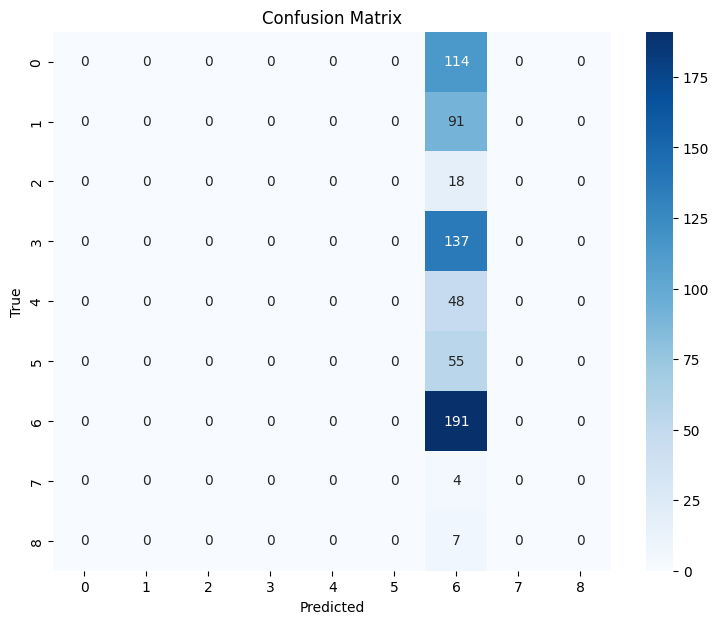

Saved: model.pth, text_processor.pkl, le_gene.pkl, le_variation.pkl


In [2]:
# ================================
# DEEP LEARNING MODEL (NO PRETRAINED) – GPU
# Dataset: MSKCC Personalized Medicine
# Model: CNN (text) + Dense (tabular) → Fusion → 9-class
# ================================

import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
from collections import Counter

# -------------------------------
# 0. GPU + CSV FIX
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
csv.field_size_limit(1000000)

# -------------------------------
# 1. LOAD DATA (Safe Parser)
# -------------------------------
print("Loading data...")

variants = pd.read_csv('/content/training_variants.csv')
print(f"Variants: {variants.shape}")

def safe_load_text(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '||' not in line: continue
            parts = line.split('||', 1)
            if len(parts) != 2: continue
            id_part, text = parts
            try:
                id_val = int(id_part.split(',')[-1])
                data.append([id_val, text])
            except: continue
    return pd.DataFrame(data, columns=['ID', 'Text'])

text = safe_load_text('/content/training_text.csv')
df = pd.merge(variants, text, on='ID', how='left')
df['Text'] = df['Text'].fillna('')
print(f"Final: {df.shape}")

# -------------------------------
# 2. TEXT PREPROCESSING (from scratch)
# -------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['Text'] = df['Text'].apply(clean_text)

# Build vocabulary
all_words = ' '.join(df['Text']).split()
vocab = ['<PAD>', '<UNK>'] + [w for w, c in Counter(all_words).most_common(10000)]
word2idx = {w: i for i, w in enumerate(vocab)}
VOCAB_SIZE = len(vocab)
MAX_LEN = 256

def text_to_indices(text):
    return [word2idx.get(w, 1) for w in text.split()[:MAX_LEN]] + [0] * (MAX_LEN - len(text.split()[:MAX_LEN]))

X_text_indices = df['Text'].apply(text_to_indices).tolist()
X_text_indices = np.array(X_text_indices)

# -------------------------------
# 3. TABULAR ENCODING
# -------------------------------
le_gene = LabelEncoder()
le_var = LabelEncoder()
df['Gene_encoded'] = le_gene.fit_transform(df['Gene'])
df['Variation_encoded'] = le_var.fit_transform(df['Variation'])
X_tab = df[['Gene_encoded', 'Variation_encoded']].values.astype(np.float32)

# Labels
y = df['Class'].values - 1

# Split
X_text_train, X_text_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_text_indices, X_tab, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------
# 4. PyTorch Dataset
# -------------------------------
class MutationDataset(Dataset):
    def __init__(self, text_indices, tabular, labels):
        self.text = torch.tensor(text_indices, dtype=torch.long)
        self.tab = torch.tensor(tabular, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return self.text[i], self.tab[i], self.labels[i]

train_ds = MutationDataset(X_text_train, X_tab_train, y_train)
test_ds = MutationDataset(X_text_test, X_tab_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# -------------------------------
# 5. DEEP LEARNING MODEL (FROM SCRATCH)
# -------------------------------
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_filters=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv = nn.Conv1d(embed_dim, num_filters, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters, 64)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(2)
        return self.fc(x)

class PersonalizedMedicineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_cnn = TextCNN(VOCAB_SIZE)
        self.tab_net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(), nn.Dropout(0.3), nn.Linear(32, 64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 9)
        )

    def forward(self, text, tab):
        t = self.text_cnn(text)
        s = self.tab_net(tab)
        x = torch.cat([t, s], dim=1)
        return self.classifier(x)

model = PersonalizedMedicineNet().to(device)

# -------------------------------
# 6. TRAINING (GPU)
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 15
best_auc = 0

print("Training on GPU...")
for epoch in range(EPOCHS):
    model.train()
    for text, tab, labels in train_loader:
        text, tab, labels = text.to(device), tab.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(text, tab)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    preds, probs, true = [], [], []
    with torch.no_grad():
        for text, tab, labels in test_loader:
            text, tab = text.to(device), tab.to(device)
            out = model(text, tab)
            prob = torch.softmax(out, 1).cpu().numpy()
            pred = out.argmax(1).cpu().numpy()
            preds.extend(pred); probs.extend(prob); true.extend(labels.numpy())

    f1 = f1_score(true, preds, average='macro')
    auc = roc_auc_score(label_binarize(true, classes=range(9)), probs, average='macro', multi_class='ovr')
    print(f"Epoch {epoch+1} | F1: {f1:.3f} | AUC: {auc:.3f}")
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), 'model.pth')
        print("  → Saved best model")

print(f"\nTraining Done! Best AUC: {best_auc:.3f}")

# -------------------------------
# 7. FINAL EVAL + CONFUSION
# -------------------------------
model.load_state_dict(torch.load('model.pth'))
model.eval()
preds, probs, true = [], [], []
with torch.no_grad():
    for text, tab, labels in test_loader:
        text, tab = text.to(device), tab.to(device)
        out = model(text, tab)
        prob = torch.softmax(out, 1).cpu().numpy()
        pred = out.argmax(1).cpu().numpy()
        preds.extend(pred); probs.extend(prob); true.extend(labels.numpy())

print("\nFINAL RESULTS")
print(classification_report(true, preds, target_names=[f"Class {i}" for i in range(1,10)]))
print(f"Macro F1: {f1_score(true, preds, average='macro'):.3f}")
print(f"ROC-AUC: {roc_auc_score(label_binarize(true, classes=range(9)), probs, average='macro'):.3f}")

plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(true, preds), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# -------------------------------
# 8. SAVE ARTIFACTS
# -------------------------------
torch.save(model.state_dict(), 'model.pth')
joblib.dump({'word2idx': word2idx, 'vocab': vocab}, 'text_processor.pkl')
joblib.dump(le_gene, 'le_gene.pkl')
joblib.dump(le_var, 'le_variation.pkl')
print("Saved: model.pth, text_processor.pkl, le_gene.pkl, le_variation.pkl")